# What do Australians think of Donald Trump and the use of tariffs on Mastodon?

<p align="center">
  <img src="https://www.bu.edu/files/2024/07/donald-trump-political-violence-qa_feat.jpg" width="325" height="200"/>
  <img src="https://cdn.prod.website-files.com/630b302c741fe7a987396dd0/67a2593507271f23b2cfc425_trump-tariff-impact.webp" width="325" height="200"/>
</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
import re
from datetime import datetime
import requests
import plotly.express as px

In [ ]:
url = "http://localhost:9090/analysis/date/2025-05-12"

response = requests.get(url)
data = response.json()

df = pd.DataFrame(data)
df

,avg_sentiment,count,keyword
0,-0.041,2824,trump
1,0.061,242,donald trump
2,0.075,23,trumpism
3,-0.296,4,trumpian
4,0.625,1,make america great again


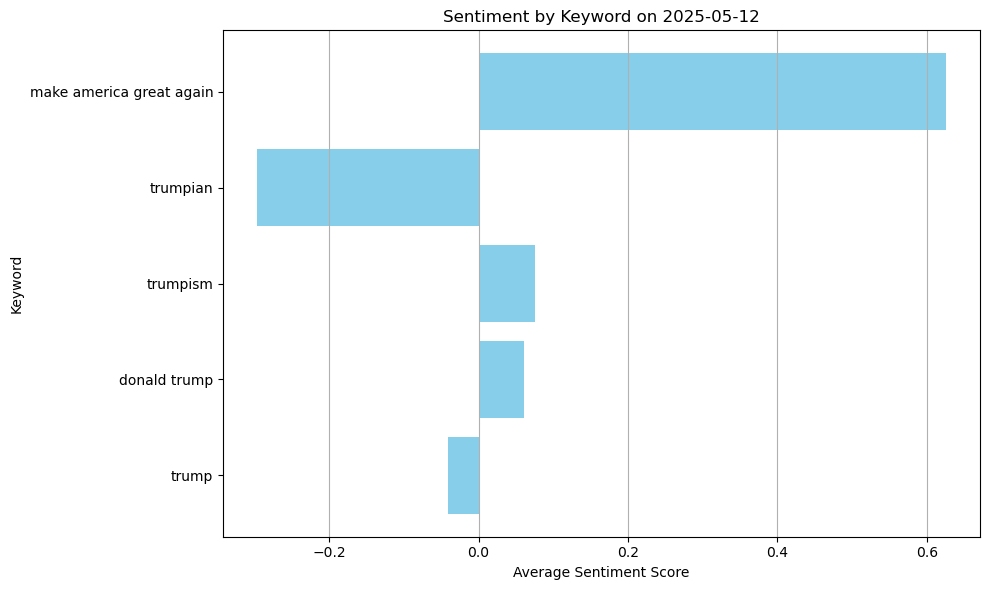

In [ ]:
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘图
plt.barh(df['keyword'], df['avg_sentiment'], color='skyblue')
plt.xlabel("Average Sentiment Score")
plt.ylabel("Keyword")
plt.title("Sentiment by Keyword on 2025-05-12")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


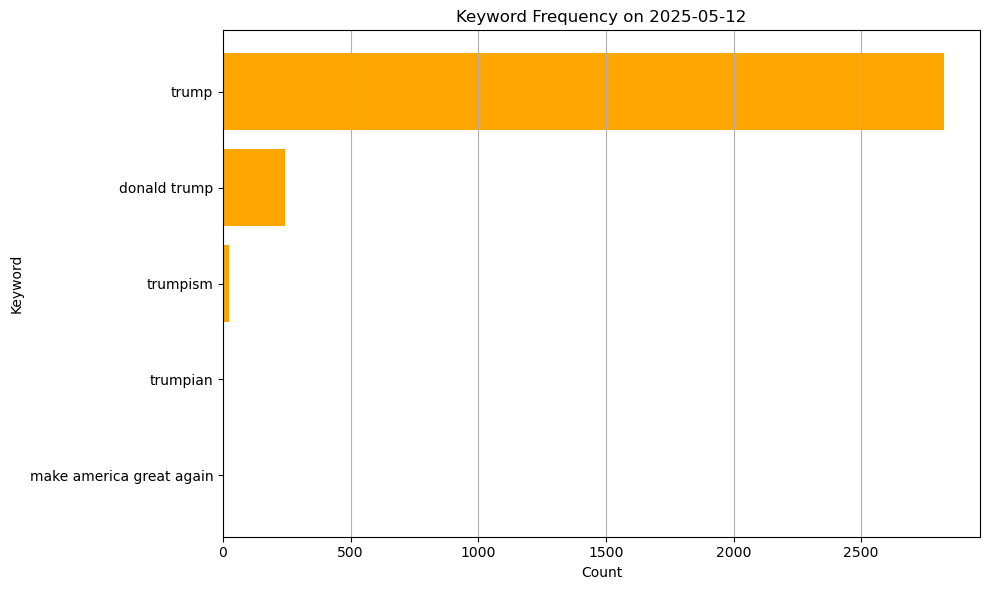

In [9]:
df_sorted = df.sort_values(by="count", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_sorted['keyword'], df_sorted['count'], color='orange')
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.title("Keyword Frequency on 2025-05-12")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [10]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%b %d, %Y @ %H:%M:%S.%f')
df['avg_sentiment'] = pd.to_numeric(df['avg_sentiment'], errors='coerce')
# 提取小时和日期信息
df['hour'] = df['created_at'].dt.hour
df['date'] = df['created_at'].dt.date
# 提取周几（例如：Monday, Tuesday 等）
df['day_of_week'] = df['created_at'].dt.day_name()

KeyError: 'created_at'

In [ ]:
# 最喜欢trump前5个用户
def show_fans(df):
    filtered = df[df['avg_sentiment'] != 0]
    users = filtered.sort_values('avg_sentiment', ascending=False).head(5)
    return users[['user', 'avg_sentiment']]


print("Top 5 users like trump\n", show_fans(df))

In [ ]:
# 最讨厌trump前5个用户
def show_haters(df):
    filtered = df[df['avg_sentiment'] != 0]
    users = filtered.sort_values('avg_sentiment', ascending=True).head(5)
    return users[['user', 'avg_sentiment']]


print("Top 5 users hate trump\n", show_haters(df))

In [ ]:
# 统计source分布
def show_source(df):
    source_counts = df['source'].value_counts()

    plt.figure(figsize=(8, 5))
    plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Source Distribution of Users')
    plt.show()

In [ ]:
# 按天的发帖量分布
def show_distribution_day(df):
    # 提取日期部分
    df['date_only'] = df['created_at'].dt.date

    # 统计每天的帖子数量
    daily_post_counts = df['date_only'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=daily_post_counts.index, y=daily_post_counts.values, order=daily_post_counts.index)
    plt.title('Daily Post Volume Distribution')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=60) 
    plt.tight_layout()  
    plt.show()

In [ ]:
category = [
    'Highly Positive',
    'Positive',
    'Neutral',
    'Negative',
    'Highly Negative'
]

# 情感分类统计图
def show_sentiment_category(df, category):
    def categorize_sentiment(score):
        sentiment = ""
        if score > 0.5:
            sentiment = category[0]
        elif score > 0.1:
            sentiment = category[1]
        elif score > -0.1:
            sentiment = category[2]
        elif score > -0.5:
            sentiment = category[3]
        else:
            sentiment = category[4]
        return sentiment

    df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

    # 情感类别分布
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, y='sentiment_category', order=['Highly Positive', 'Positive', 'Neutral', 'Negative', 'Highly Negative'])
    plt.title('Distribution of Sentiment Categories')
    plt.xlabel('Count')
    plt.ylabel('Sentiment Category')
    plt.show()

In [ ]:
# 一段时间内的情感分数变化
def show_sentiment_trend(df):
    # 提取日期信息
    df['date_only'] = df['created_at'].dt.date

    # 按天统计平均情感得分
    daily_sentiment = df.groupby('date_only')['sentiment_score'].mean().reset_index()

    plt.figure(figsize=(10, 6))  # 增加图表宽度
    plt.plot(daily_sentiment['date_only'], daily_sentiment['sentiment_score'], marker='o')
    plt.title('Daily Average Sentiment Trend')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=60)  # 增加旋转角度以避免重叠
    plt.tight_layout()  # 自动调整布局
    plt.show()

In [ ]:
# 互动式气泡图 + 时间序列情绪流动图
def show_sentiment_bubble(df):
    # 确保 created_at 是 datetime 类型
    if not pd.api.types.is_datetime64_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])

    df['date_only'] = df['created_at'].dt.date
    df['normalized_size'] = (df['sentiment_score'] - df['sentiment_score'].min()) / \
                            (df['sentiment_score'].max() - df['sentiment_score'].min()) * 19 + 1

    # 使用 Plotly 创建互动式气泡图
    fig = px.scatter(
        df,
        x='created_at',
        y='sentiment_score',
        size='normalized_size',  # 使用归一化后的尺寸
        color='date_only',  # 按日期上色
        hover_name='date_only',
        hover_data=['content'],  # 显示具体帖子内容
        title='Sentiment Score Bubble Chart (Interactive)',
        labels={'created_at': 'Date', 'sentiment_score': 'Sentiment Score'},
    )

    # 更新布局以启用拖动和缩放，并设置 y 轴范围
    fig.update_layout(
        dragmode='zoom',
        yaxis=dict(range=[-1, 1], fixedrange=False),  # 设置 y 轴范围为 [-1, 1]
        xaxis=dict(rangeslider=dict(visible=True)),  # 添加范围滑块
    )

    fig.show()

In [ ]:
# 动态可视化展示随时间推移的情绪变化
def show_sentiment_animation(df):
    # 确保 created_at 是 datetime 类型
    if not pd.api.types.is_datetime64_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])

    # 提取日期信息，用于可视化
    df['date'] = df['created_at'].dt.date

    # 为了检测"Trump"话题
    df['has_trump'] = df['content'].str.contains('(?i)trump', regex=True)

    # 按日期和小时分组，计算平均情感得分和Trump话题比例
    daily_data = df.groupby(['date', 'hour']).agg({
        'sentiment_score': 'mean',
        'has_trump': 'mean',  # Trump话题的比例
        'id': 'count'  # 帖子数量
    }).reset_index()

    # 为更好的可视化，添加时间字段
    daily_data['datetime'] = pd.to_datetime(daily_data['date']) + pd.to_timedelta(daily_data['hour'], unit='h')

    # 创建带有动画效果的散点图
    fig = px.scatter(
        daily_data,
        x='hour',
        y='sentiment_score',
        size='id',  # 气泡大小表示帖子数量
        color='has_trump',  # 颜色表示Trump话题比例
        animation_frame='date',  # 按日期进行动画
        range_y=[-1, 1],  # 固定y轴范围
        range_x=[0, 23],  # 固定x轴范围
        color_continuous_scale='RdBu',  # 红蓝色彩比例
        title='情绪变化与Trump话题热度随时间推移的动态变化',
        labels={
            'hour': '小时 (0-23)',
            'sentiment_score': '平均情感得分',
            'id': '帖子数量',
            'has_trump': 'Trump话题比例',
            'date': '日期'
        },
        height=600,
        size_max=50  # 气泡最大尺寸
    )

    # 添加动画按钮和播放控制
    fig.update_layout(
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [{
                'label': '播放',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]
            }, {
                'label': '暂停',
                'method': 'animate',
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}]
            }]
        }]
    )

    fig.show()

In [ ]:
# 时间推进动画展示情绪变化
def show_emotion_timeline_animation(df):
    # 确保数据类型正确
    if not pd.api.types.is_datetime64_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])
    
    # 提取日期和小时
    df['date'] = df['created_at'].dt.date
    df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
    
    # 按照时间间隔（每4小时）聚合数据
    df['time_bin'] = pd.cut(df['hour'], bins=6, labels=['Midnight(0-4)', 'Morning(4-8)', 'Noon(8-12)', 
                                                         'Afternoon(12-16)', 'Evening(16-20)', 'Night(20-24)'])
    
    # 统计每天各时段的情感分布
    time_emotion = df.groupby(['date', 'time_bin']).agg({
        'sentiment_score': ['mean', 'count', 'std'],
        'content': lambda x: np.mean(x.str.contains('(?i)trump', regex=True))  # 直接计算Trump提及比例
    }).reset_index()
    
    # 重命名列
    time_emotion.columns = ['date', 'time_bin', 'avg_sentiment', 'post_count', 'sentiment_std', 'trump_ratio']
    
    # 创建新的动画可视化
    fig = px.scatter(
        time_emotion,
        x='time_bin',
        y='avg_sentiment',
        size='post_count',
        color='trump_ratio',
        animation_frame='date',  # 按日期动画展示
        error_y='sentiment_std',  # 显示标准差
        color_continuous_scale='Viridis',  # 使用Viridis颜色映射
        range_y=[-1, 1],  # 固定y轴范围
        size_max=60,  # 最大气泡尺寸
        title='Emotional Changes During Different Times of Day (Dynamic)',
        labels={
            'time_bin': 'Time Period',
            'avg_sentiment': 'Average Sentiment Score',
            'post_count': 'Post Count',
            'trump_ratio': 'Trump Mention Ratio',
            'date': 'Date',
            'sentiment_std': 'Sentiment Score Std'
        },
        height=600,
        width=900
    )
    
    # 美化图表
    fig.update_layout(
        xaxis_title='Time of Day',
        yaxis_title='Average Sentiment Score (-1:Negative to 1:Positive)',
        coloraxis_colorbar=dict(
            title='Trump Topic Ratio'
        ),
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'y': 1.05,
            'x': 0.15,
            'xanchor': 'left',
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 800, 'redraw': True}, 'fromcurrent': True,
                                'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}]
            }, {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                                  'transition': {'duration': 0}}]
            }]
        }],
        # 添加滑动条控制播放速度
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 16},
                'prefix': 'Date: ',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {
                    'method': 'animate',
                    'label': str(date),
                    'args': [[str(date)], {
                        'frame': {'duration': 300, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 300}
                    }]
                } for date in sorted(time_emotion['date'].unique())
            ]
        }]
    )
    
    # 添加注释说明
    fig.add_annotation(
        x=0.5,
        y=-0.15,
        xref='paper',
        yref='paper',
        text='Bubble size: Post count, Color: Trump topic ratio, Error bars: Sentiment score standard deviation',
        showarrow=False,
        font=dict(size=12),
        align='center'
    )
    
    fig.show()

In [ ]:
# 用plotly实现时间推进动画
def show_sentiment_matplotlib_animation(df):
    """
    Create a web-based interactive animation showing sentiment trends over time
    using Plotly instead of matplotlib
    """
    # 确保数据类型正确
    if not pd.api.types.is_datetime64_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])
    
    # 提取日期
    df['date'] = df['created_at'].dt.date
    
    # 按日期分组计算情感得分和Trump提及情况
    sentiment_by_date = df.groupby('date').agg({
        'sentiment_score': ['mean', 'median', 'std', 'count'],
        'content': lambda x: np.mean(x.str.contains('(?i)trump', regex=True))  # 直接计算Trump提及比例
    })
    
    # 重置列名
    sentiment_by_date.columns = ['mean_score', 'median_score', 'std_score', 'post_count', 'trump_ratio']
    sentiment_by_date = sentiment_by_date.reset_index()
    
    # 将日期转为连续数值表示，用于滑动条
    sentiment_by_date['date_num'] = (sentiment_by_date['date'] - sentiment_by_date['date'].min()).dt.days
    
    # 创建一个包含所有帧的完整数据集
    frames_data = []
    for i in range(1, len(sentiment_by_date) + 1):
        data_subset = sentiment_by_date.iloc[:i].copy()
        # 标记当前最新点
        data_subset['is_latest'] = False
        data_subset.iloc[-1, data_subset.columns.get_loc('is_latest')] = True
        # 添加帧ID
        data_subset['frame_id'] = i
        frames_data.append(data_subset)
    
    # 合并所有帧数据
    all_frames_data = pd.concat(frames_data)
    
    # 创建颜色映射
    def get_color_scale(score):
        if score > 0.2:
            return 'green'
        elif score < -0.2:
            return 'red'
        else:
            return 'gray'
    
    all_frames_data['color'] = all_frames_data['mean_score'].apply(get_color_scale)
    
    # 创建Plotly动画散点图
    fig = px.scatter(
        all_frames_data,
        x='date_num',
        y='mean_score',
        size='post_count',
        color='mean_score',
        animation_frame='frame_id',
        range_y=[-1, 1],
        range_x=[-1, sentiment_by_date['date_num'].max() + 1],
        color_continuous_scale='RdBu',
        color_continuous_midpoint=0,
        labels={
            'date_num': 'Days',
            'mean_score': 'Average Sentiment Score',
            'post_count': 'Post Count',
            'trump_ratio': 'Trump Topic Ratio'
        },
        title='Sentiment and Trump Topic Ratio Changes Over Time',
        height=600,
        width=900
    )
    
    # 添加Trump话题比例线
    for frame_idx, frame in enumerate(fig.frames):
        current_data = sentiment_by_date.iloc[:frame_idx+1]
        
        # 添加Trump话题比例线
        frame.data += (
            px.line(
                current_data, 
                x='date_num', 
                y='trump_ratio'
            ).update_traces(
                yaxis='y2',
                line=dict(color='purple', width=2),
                name='Trump Topic Ratio'
            ).data
        )
        
        # 添加标注
        if not current_data.empty:
            last_point = current_data.iloc[-1]
            frame.data += (
                px.scatter(
                    pd.DataFrame([last_point]), 
                    x='date_num', 
                    y='mean_score'
                ).update_traces(
                    marker=dict(color='yellow', size=15, line=dict(width=2, color='black')),
                    name='Latest Point',
                    hovertemplate=f'<b>Date:</b> {last_point["date"]}<br>' +
                                  f'<b>Sentiment:</b> {last_point["mean_score"]:.2f}<br>' +
                                  f'<b>Posts:</b> {last_point["post_count"]}<br>' +
                                  f'<b>Trump Ratio:</b> {last_point["trump_ratio"]:.2f}'
                ).data
            )
    
    # 更新初始视图
    fig.update_traces(
        hovertemplate='<b>Date:</b> %{customdata[0]}<br>' +
                      '<b>Sentiment:</b> %{y:.2f}<br>' +
                      '<b>Posts:</b> %{customdata[1]}<br>' +
                      '<b>Trump Ratio:</b> %{customdata[2]:.2f}',
        customdata=all_frames_data[all_frames_data['frame_id'] == 1][['date', 'post_count', 'trump_ratio']]
    )
    
    # 创建双Y轴
    fig.update_layout(
        xaxis_title='Days',
        yaxis=dict(
            title='Average Sentiment Score',
            range=[-1, 1],
            gridcolor='lightgray'
        ),
        yaxis2=dict(
            title='Trump Topic Ratio',
            range=[0, 1],
            side='right',
            overlaying='y',
            tickmode='sync',
            gridcolor='lightgray',
            titlefont=dict(color='purple'),
            tickfont=dict(color='purple')
        ),
        # 添加图例
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        ),
        # 添加参考线
        shapes=[
            dict(
                type='line',
                y0=0, y1=0,
                x0=-1, x1=sentiment_by_date['date_num'].max() + 1,
                line=dict(color='gray', dash='dash', width=1)
            ),
            dict(
                type='line',
                y0=0.2, y1=0.2,
                x0=-1, x1=sentiment_by_date['date_num'].max() + 1,
                line=dict(color='green', dash='dot', width=1)
            ),
            dict(
                type='line',
                y0=-0.2, y1=-0.2,
                x0=-1, x1=sentiment_by_date['date_num'].max() + 1,
                line=dict(color='red', dash='dot', width=1)
            )
        ],
        # 添加播放控制
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'y': 0,
            'x': 0.1,
            'xanchor': 'right',
            'yanchor': 'top',
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': 300, 'redraw': True},
                    'fromcurrent': True,
                    'transition': {'duration': 100, 'easing': 'quadratic-in-out'}
                }]
            }, {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': False},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }]
        }],
        # 添加滑动条
        sliders=[{
            'active': 0,
            'steps': [
                {
                    'method': 'animate',
                    'label': str(i),
                    'args': [[i], {
                        'frame': {'duration': 300, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                }
                for i in range(1, len(sentiment_by_date) + 1)
            ],
            'transition': {'duration': 100},
            'x': 0.1,
            'y': 0,
            'len': 0.9,
            'currentvalue': {
                'visible': True,
                'prefix': 'Day: ',
                'xanchor': 'right',
                'font': {'size': 12, 'color': '#666'}
            }
        }],
        # 设置背景和网格线
        plot_bgcolor='white',
        margin=dict(t=60, l=80, r=80, b=80)
    )
    
    # 显示图表
    fig.show()


In [ ]:
# 关键词情绪趋势折线图函数,可改为别的关键词
def show_keyword_sentiment_trend(df, keyword='trump', time_unit='day'):
    """
    Display sentiment trends for a specific keyword over time
    """
    # 确保数据类型正确
    if not pd.api.types.is_datetime64_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])

    # 提取包含关键词的帖子
    keyword_pattern = f"(?i){keyword}"
    keyword_posts = df[df['content'].str.contains(keyword_pattern, regex=True)]

    if keyword_posts.empty:
        print(f"No posts found containing keyword '{keyword}'")
        return

    # 根据时间单位分组
    if time_unit == 'hour':
        # 按小时分组
        keyword_posts['time_group'] = keyword_posts['created_at'].dt.strftime('%Y-%m-%d %H:00')
    elif time_unit == 'week':
        # 按周分组
        keyword_posts['time_group'] = keyword_posts['created_at'].dt.strftime('%Y-%W')
    else:
        # 默认按天分组
        keyword_posts['time_group'] = keyword_posts['created_at'].dt.date

    # 计算各时间点的平均情感得分
    sentiment_over_time = keyword_posts.groupby('time_group').agg({
        'sentiment_score': ['mean', 'count', 'std'],
    }).reset_index()

    # 重命名列
    sentiment_over_time.columns = ['time_group', 'avg_sentiment', 'post_count', 'sentiment_std']

    # 添加情感类别
    def categorize_sentiment(score):
        if score > 0.2:
            return 'Positive'
        elif score < -0.2:
            return 'Negative'
        else:
            return 'Neutral'

    sentiment_over_time['sentiment_category'] = sentiment_over_time['avg_sentiment'].apply(categorize_sentiment)

    # 计算各类情感的累计数量
    category_counts = sentiment_over_time.groupby(['time_group', 'sentiment_category']).size().unstack().fillna(0)
    if not category_counts.empty and set(['Positive', 'Negative', 'Neutral']).issubset(category_counts.columns):
        sentiment_over_time = sentiment_over_time.merge(category_counts, on='time_group', how='left')

    # 确保时间顺序正确
    sentiment_over_time = sentiment_over_time.sort_values('time_group')

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

    # 1. 情绪得分折线图 (主图)
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Sentiment Score', color=color)
    line1 = ax1.plot(sentiment_over_time['time_group'], sentiment_over_time['avg_sentiment'],
                    marker='o', linestyle='-', color=color, linewidth=2, markersize=8)
    ax1.tick_params(axis='y', labelcolor=color)

    # 添加帖子数量条形图
    ax1_twin = ax1.twinx()
    color = 'tab:red'
    ax1_twin.set_ylabel('Post Count', color=color)
    bars = ax1_twin.bar(sentiment_over_time['time_group'], sentiment_over_time['post_count'],
                        alpha=0.3, color=color)
    ax1_twin.tick_params(axis='y', labelcolor=color)

    # 添加标准差区域
    ax1.fill_between(
        sentiment_over_time['time_group'],
        sentiment_over_time['avg_sentiment'] - sentiment_over_time['sentiment_std'],
        sentiment_over_time['avg_sentiment'] + sentiment_over_time['sentiment_std'],
        alpha=0.2, color='tab:blue'
    )

    # 添加水平参考线
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax1.axhline(y=0.2, color='green', linestyle=':', alpha=0.5)
    ax1.axhline(y=-0.2, color='red', linestyle=':', alpha=0.5)

    # 2. 情感类别堆叠区域图 (下图)
    if set(['Positive', 'Negative', 'Neutral']).issubset(sentiment_over_time.columns):
        ax2.stackplot(sentiment_over_time['time_group'],
                    sentiment_over_time['Positive'],
                    sentiment_over_time['Neutral'],
                    sentiment_over_time['Negative'],
                    labels=['Positive', 'Neutral', 'Negative'],
                    colors=['#2ecc71', '#f1c40f', '#e74c3c'], alpha=0.7)
        ax2.legend(loc='upper left')
    else:
        # 如果没有足够的情感类别数据，显示情感类别计数
        sns.countplot(data=sentiment_over_time, x='time_group', hue='sentiment_category', ax=ax2)
        ax2.legend(title='Sentiment Category')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Sentiment Category Distribution')

    # 设置x轴标签
    if len(sentiment_over_time) > 12:
        # 如果数据点过多，每隔几个显示一个标签
        step = max(1, len(sentiment_over_time) // 10)
        for ax in [ax1, ax2]:
            for i, label in enumerate(ax.get_xticklabels()):
                if i % step != 0:
                    label.set_visible(False)

    # 旋转x轴标签
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # 设置标题
    fig.suptitle(f"Sentiment Trends for Keyword '{keyword}' (by {time_unit})", fontsize=16)

    # 添加网格线
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    # 使用Plotly创建交互式情绪趋势图
    try:
        # 创建Plotly图表
        fig = px.line(
            sentiment_over_time,
            x='time_group',
            y='avg_sentiment',
            error_y='sentiment_std',
            hover_data=['post_count', 'sentiment_category'],
            title=f"Sentiment Trends for Keyword '{keyword}' (Interactive)",
            labels={
                'time_group': 'Time',
                'avg_sentiment': 'Average Sentiment Score',
                'post_count': 'Post Count',
                'sentiment_category': 'Sentiment Category'
            },
            markers=True
        )

        # 添加帖子数量条形图
        fig.add_bar(
            x=sentiment_over_time['time_group'],
            y=sentiment_over_time['post_count'],
            name='Post Count',
            opacity=0.3,
            yaxis='y2'
        )

        # 设置双y轴
        fig.update_layout(
            yaxis2=dict(
                title='Post Count',
                overlaying='y',
                side='right'
            ),
            hovermode='x unified'
        )

        # 添加参考线
        fig.add_hline(y=0, line_dash='dash', line_color='gray', opacity=0.7)
        fig.add_hline(y=0.2, line_dash='dot', line_color='green', opacity=0.5)
        fig.add_hline(y=-0.2, line_dash='dot', line_color='red', opacity=0.5)

        fig.show()
    except Exception as e:
        print(f"Error creating Plotly interactive chart: {e}")


# 调用函数显示Trump关键词的情绪趋势 (可以改为其他关键词)
show_keyword_sentiment_trend(df, keyword='trump', time_unit='day')
